In [2]:
import numpy as np
from scipy.stats import spearmanr

%matplotlib notebook
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression

import gpc

# Motivation
We wish to understand the correlation between $\left\{x_1, x_2\right\}$ and $y$ while controlling for $z$. 



# Fiducial data
First, we generate some fiducial data such that $y = y(z)$ and $x_1$ is correlated with $z$ and $x_2$ is uncorrelated with any variable.  

<IPython.core.display.Javascript object>


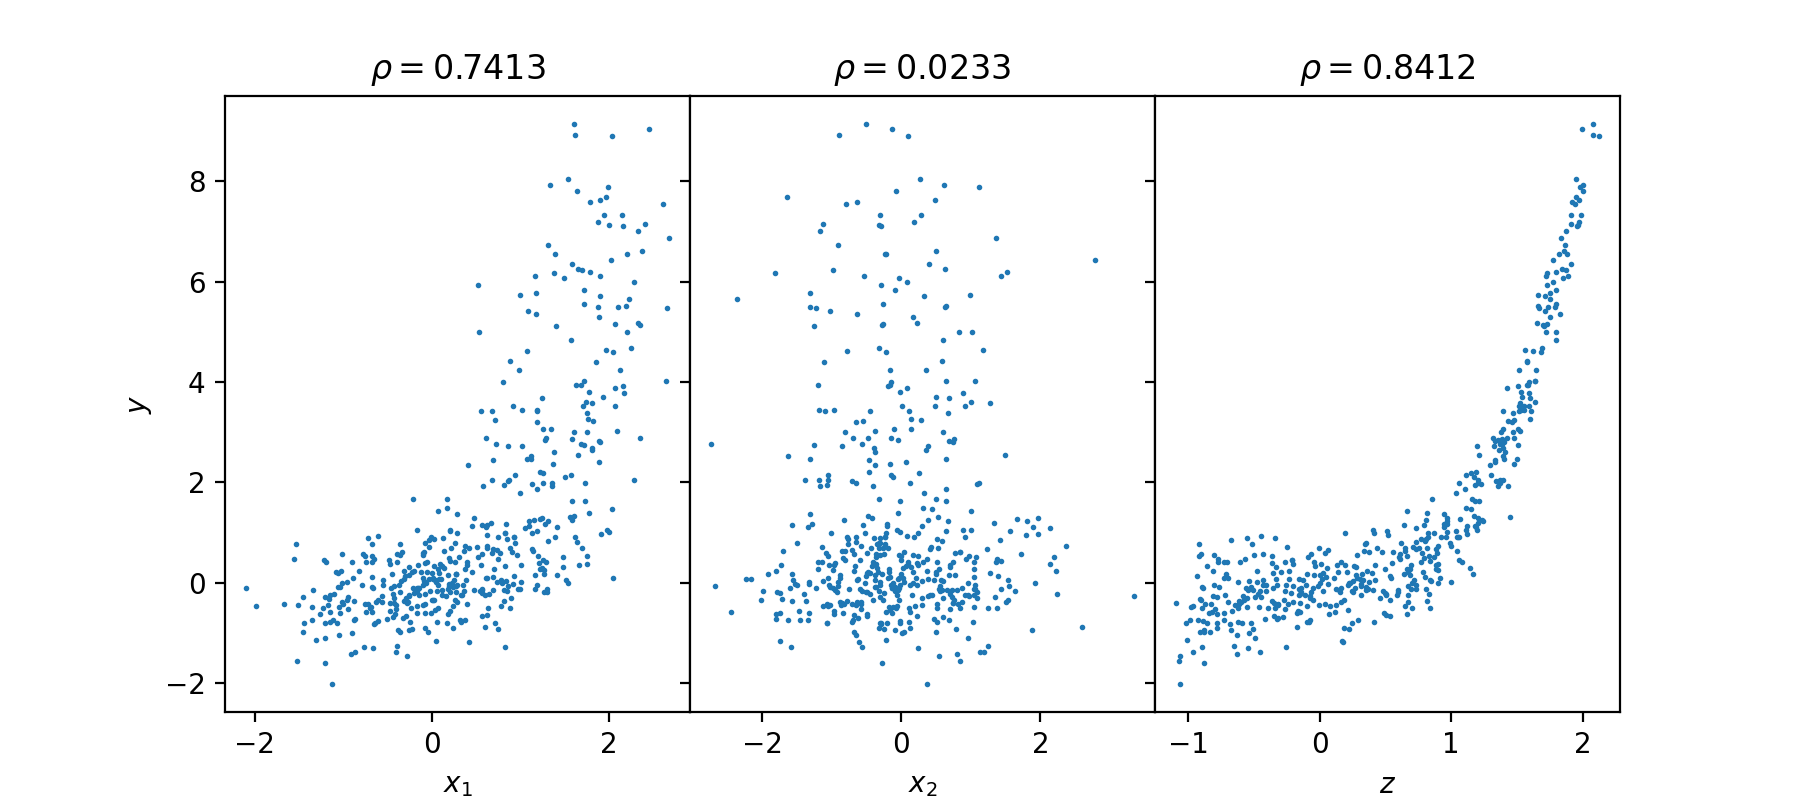

In [3]:
Npoints = 500

z = np.linspace(-1, 2, Npoints) + np.random.normal(0, 0.1, Npoints)
y = z**3 + np.random.normal(0, 0.5, Npoints)


x1 = z + np.random.normal(0, 0.5, Npoints)
x2 = np.random.normal(0, 1, Npoints)



fig, axs = plt.subplots(ncols=3, figsize=(9, 4), sharey=True)
fig.subplots_adjust(wspace=0.0)

axs[0].set_title(r"$\rho = {:.4f}$".format(spearmanr(x1, y)[0]))
axs[0].scatter(x1, y, s=1)

axs[1].set_title(r"$\rho = {:.4f}$".format(spearmanr(x2, y)[0]))
axs[1].scatter(x2, y, s=1)

axs[2].set_title(r"$\rho = {:.4f}$".format(spearmanr(z, y)[0]))
axs[2].scatter(z, y, s=1)


axs[0].set_xlabel(r"$x_1$")
axs[1].set_xlabel(r"$x_2$")
axs[2].set_xlabel(r"$z$")
axs[0].set_ylabel(r"$y$")

fig.show()

# Partial correlation

Partial correlation is calculated as outlined here [here](https://en.wikipedia.org/wiki/Partial_correlation). The residuals can be calculated using any `scikit-learn`-like model. Here we showcase a linear model (traditional partial correlation) and a Gaussian process model.

## Masks for train-test splitting

We optionally support train-test masking to a number of folds of the original data set. In the test masks below, the model is trained at each turn on the training set only.

In [4]:
n_splits = 50
test_masks = np.zeros((n_splits, Npoints), dtype=bool)
for i in range(n_splits):
    m = np.random.choice(Npoints, int(Npoints / 5), replace=False)
    test_masks[i, m] = True

## Linear Model

In [5]:
X = np.vstack([x1, x2]).T
model = LinearRegression()

dxz, dyz, fullout = gpc.get_reg_residuals(model, X, y, z, test_masks, verbose=False)
# Average the residuals over folds
dxz = gpc.fold_average(dxz)
dyz = gpc.fold_average(dyz)

linear_pc = gpc.partial_correlation(dxz, dyz)

## Gaussian Process Model

In [6]:
X = np.vstack([x1, x2]).T
kernel = RBF() + WhiteKernel()
model = GaussianProcessRegressor(kernel)

dxz, dyz, fullout = gpc.get_reg_residuals(model, X, y, z, test_masks, verbose=True)
# Average the residuals over folds
dxz = gpc.fold_average(dxz)
dyz = gpc.fold_average(dyz)

gpr_pc = gpc.partial_correlation(dxz, dyz)

100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  2.96it/s]


In [14]:
print("Partial correlation between x1 and y (originally correlated through z):")
print("Linear: rho = {:.4f}, p = {:.4f}".format(*linear_pc[0, :]))
print("GPR: rho = {:.4f}, p = {:.4f}".format(*gpr_pc[0, :]))

print()

print("Partial correlation between x2 and y (originally uncorrelated):")
print("Linear: rho = {:.4f}, p = {:.4f}".format(*linear_pc[1, :]))
print("GPR: rho = {:.4f}, p = {:.4f}".format(*gpr_pc[1, :]))


Partial correlation between x1 and y (originally correlated through z):
Linear: rho = -0.0009, p = 0.9847
GPR: rho = 0.0320, p = 0.4759

Partial correlation between x2 and y (originally uncorrelated):
Linear: rho = -0.0460, p = 0.3050
GPR: rho = -0.0045, p = 0.9195
